## final project submission

Please fill out:
* Student name: Claire Sarraille
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor




%matplotlib inline

## crisp-dm:

- Business Understanding
    - Who will be  using the model
    - How will the model be used
    - How will using the model help our business
    - clarify requirements
    - What problems are in and out of scope

- Understand Data
    - What is target
    - What are predictors
    - Distribution of Data
    - How many observations - and is this a small, medium or large collection?
    - What is the quality? - What errors could be in the data, or inaccuracy?

- Data Preparation - Prepping to model
    - Missing values
    - Type conversions
    - Remove multicollinearity (correlated predictors)
    - Normalize numeric data
    - Convert categorical data to numeric via one-hot encoding

- Modeling:
    - Tune models to get the highest performance possible on our task
    - Considerations:
        - What kind of task? Classification task? Regression task?
        - Which models will we use
        - Will we use regularization?
        - How will we validate our model?
        - Loss functions?
        - What is the performance threshold for success?

- Evaluation:
    - Does the model solve business problem outlined in step 1?
    - At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
    - Things we may learn at this stage:
        - Need different data
        - Need more data
        - Should be going in a different direction
        - Should use classificaion rather than regression, or vice versa
        - Use different approach

- Deployment:
    - Move the model into production
    - Set up ETL - how much of preprocessing and cleaning can be automated?


# BUSINESS UNDERSTANDING
- Who will be  using the model
    - The real estate agency I work for
- How will the model be used
    - Help home owners buy and/or sell homes - we're targeting AVERAGE single family homes - 4 bedrooms, around 1600-1650 square feet -- how can we remove outliers?
- How will using the model help our business
    - We can give good advice to homeowners about how home renovations might increase the estimate value of their homes, and by how much
    - This will increase the amount of sales, thus increasing both our's and the home owner's profits
- clarify requirements
    - Find the features that are highest correlated with a higher sell price. Find how many dollars each unit of each feature adds to price
    - Use these correlations to recommend home renovations, ranked by the most to least positive impact on price.
- What problems are in and out of scope
    - How do home renovations impact the sell price of a home.
    - How locational factors impact price: homeowners cannot re-locate homes and we are assuming they can't change view of waterfront 

## Business Questions:
- Useful to subset data into waterfront vs. non-waterfront models?
- If a home is sold more than once in our dataset, should that impact our model?
- Remove outliers so that we're looking at average homes?
    - 4 bedrooms
    - 1600-1650 square feet
    - Subset based on 'Grade'?
- If we normalize all of our predictors so they are on the same scale (z-score normalization), how do we un-normalize these features to interpret how they impact price?
    - condition
    - square feet living space
    - bedrooms
    - bathrooms
- Are renovations WORTH the estimated increase in sale price?
    - Need to know average cost of adding a bathroom, bedrooms, increasing square-footage, etc

# UNDERSTAND DATA
- What is **target**
>'price'
- What are **predictors**
>'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built'
- Distribution of Data - See Distribution Section
- How many observations - and is this a small, medium or large collection?
    - 21,597 entries
    - According to Frank Harrell in his book Regression Modeling Strategies, you need at least 10-20 observations per predictor
    - We have many, many more observations than 20 * (6 - num covariates) = 120
    - Our dataset would be considered large
- What is the quality? - What errors could be in the data, or inaccuracy? - See Data Quality Section

## Read in Data

In [28]:
df = pd.read_csv('data/kc_house_data.csv')

## Remove features - recommended by Flatiron to remove
- date (no explanatory value)
- view ( has been viewed, this wouldn't help us predict prices) 
- Note: **sqft_above + sqft_basement = sqft_living**, according to meta-data:
    - sqft_above (repeating sqft_living)
    - sqft_basement (repeating sqft_living)
- yr_renovated (repeating yr_built)
- Not helpful to have geographic features becuase renovation can't inclue re-locating house (ostensibly)
    - zipcode
    - lat
    - long
- sqft_living15 (repeating sqft_living)
- sqft_lot15 (repeating sqft_lot)

In [29]:
# Why reduce features?
# I narrowed my list of features to avoid over-fit of the training dataset
# Reducing redundancy in features increases the accuracy of the model

df = df.drop(['date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [30]:
# Note:sqft_living includes a finished basement, if present
# Grade is the construction quality of improvements, according to a King County grading system
# Condition is overall condition of house
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

### Data Quality

- There could be outliers - such as hundreds of bathrooms - which doesn't make sense with square footage
- Year could be in the future
- price could be a negative number
- datatype could be wrong - such as string for number of bedrooms

#### Waterfront Missing Values 
I filled in NaN values for 'waterfront' with 0. Now, 'waterfront' has a 1 value if there is a view, and 0 value if there is not.
I also cast this column as an integer type since there are no other options besides the integers 1 and 0.

In [31]:
# The only field that I retained containing NaN values is waterfront:
df.isnull().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

In [32]:
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'] = df["waterfront"].astype(int)
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'].unique()

array([0, 1])

## Cast Some Features at a Different Scale for Visualization 

In [33]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560 

In [34]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [35]:
df[['price_millions','price', 'acres_lot']]

,price_millions,price,acres_lot
0,0.221900,221900.0,0.129706
1,0.538000,538000.0,0.166253
2,0.180000,180000.0,0.229568
3,0.604000,604000.0,0.114784
4,0.510000,510000.0,0.185491
...,...,...,...
21592,0.360000,360000.0,0.025964
21593,0.400000,400000.0,0.133448
21594,0.402101,402101.0,0.030992
21595,0.400000,400000.0,0.054821


In [46]:
print(f"The max price is {df['price_millions'].max()} million, min price is {df['price'].min()}")

The max price is 7.7 million, min price is 78000.0


## DISTRIBUTIONS

### Describe Data - Descriptive Statistics

#### King County's Grading System for Buildings:
##### Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1. Falls short of minimum building standards. Normally cabin or inferior structure.

2. Falls short of minimum building standards. Normally cabin or inferior structure.

3. Falls short of minimum building standards. Normally cabin or inferior structure.

4. Generally older, low quality construction. Does not meet code.

5. Low construction costs and workmanship. Small, simple design.

6. Lowest grade currently meeting building code. Low quality materials and simple designs.

7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9. Better architectural design with extra interior and exterior design and quality.

10. Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11. Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13. Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

#### King County's Condition Scale: 
##### Relative to age and grade. Coded 1-5.

1. Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2. Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4. Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5. Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

#### .describe()

In [45]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'acres_lot': '{:.2f}',  'price': '${:20,.0f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

,price,bedrooms,bathrooms,sqft_living,acres_lot,floors,waterfront,condition,grade,yr_built
count,"$ 21,597",21597.00,21597.00,"21,597.00",21597.00,21597.00,21597.00000,21597.00,21597.00,21597
mean,"$ 540,297",3.37,2.12,"2,080.32",0.35,1.49,0.00676,3.41,7.66,1971
std,"$ 367,368",0.93,0.77,918.11,0.95,0.54,0.08194,0.65,1.17,29
min,"$ 78,000",1.00,0.50,370.00,0.01,1.00,0.00000,1.00,3.00,1900
25%,"$ 322,000",3.00,1.75,"1,430.00",0.12,1.00,0.00000,3.00,7.00,1951
50%,"$ 450,000",3.00,2.25,"1,910.00",0.17,1.50,0.00000,3.00,7.00,1975
75%,"$ 645,000",4.00,2.50,"2,550.00",0.25,2.00,0.00000,4.00,8.00,1997
max,"$ 7,700,000",33.00,8.00,"13,540.00",37.91,3.50,1.00000,5.00,13.00,2015


#### Interpret .describe() 
- There are no negative values for any of the columns
- The year range makes sense: homes were built between 1900 and 2015
- sqft_living average is around 2,000, which is close to the US average
- The average lot size is 15,099 square feet, or .35 acres
- The lot size mean is skewed by our outlier home, which stands on a 37.91 acre lot.
- The median sqft_lot size is 7,618 or .17 acres, which is much closer to the national average of 0.188 of an acre.
- Condition and Grade: The mean, max, and min all line-up with the scale of the system, described above.
    - Mean Grade is 7.66, so between a 7 and 8: 
        - 7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.
        - 8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
    - Mean Condition is 3.41, closest to a 3: 
        - 3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

### Price Frequency Histogram

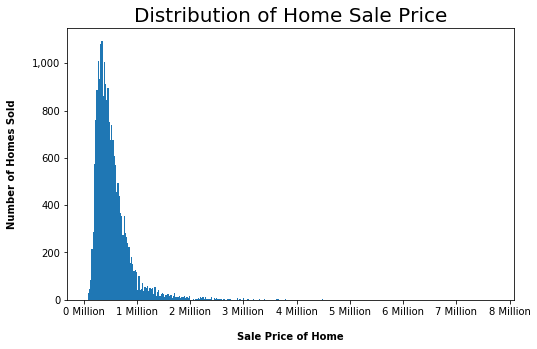

In [27]:
ax = df.hist(column='price_millions',
             bins='auto',
             grid=False,
             figsize=(8,5))

ax = ax[0]
for x in ax:

    x.set_title("Distribution of Home Sale Price", size=20)

    # Set x-axis label
    x.set_xlabel("Sale Price of Home", labelpad=15, weight='bold', size=10)
    x.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}' + ' Million'))

    # Set y-axis label
    x.set_ylabel("Number of Homes Sold", labelpad=15, weight='bold', size=10)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


### Outliers using IQR
- I'm not sure if I'll need to drop outliers
- Nonetheless it was interesting to see where the extreme outliers are located.

In [ ]:
# sns.boxplot(x=df['price_millions'])
# sns.boxplot(x=df['bedrooms'])
# sns.boxplot(x=df['bathrooms'])
# sns.boxplot(x=df['sqft_living'])
# sns.boxplot(x=df['acres_lot'])


### Outliers using Sorting

In [ ]:
# Price
# df[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot']].sort_values('price_millions', ascending = False).head(20)
# Bedrooms
# df[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot']].sort_values('bedrooms', ascending = False).head(20)
# Bathrooms
# df[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot']].sort_values('bathrooms', ascending = False).head(20) 
# sqft living 
# df[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot']].sort_values('sqft_living', ascending = False).head(20)
# acres lot
# df[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot']].sort_values('acres_lot', ascending = False).head(20)

### Scatter Matrix Distribution

In [ ]:
# Remember that our columns are:
df.columns

In [ ]:
# But our predictors are a subset:
'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built'

In [33]:
# Select a subset of columns to create matrix:
df_scatter = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]

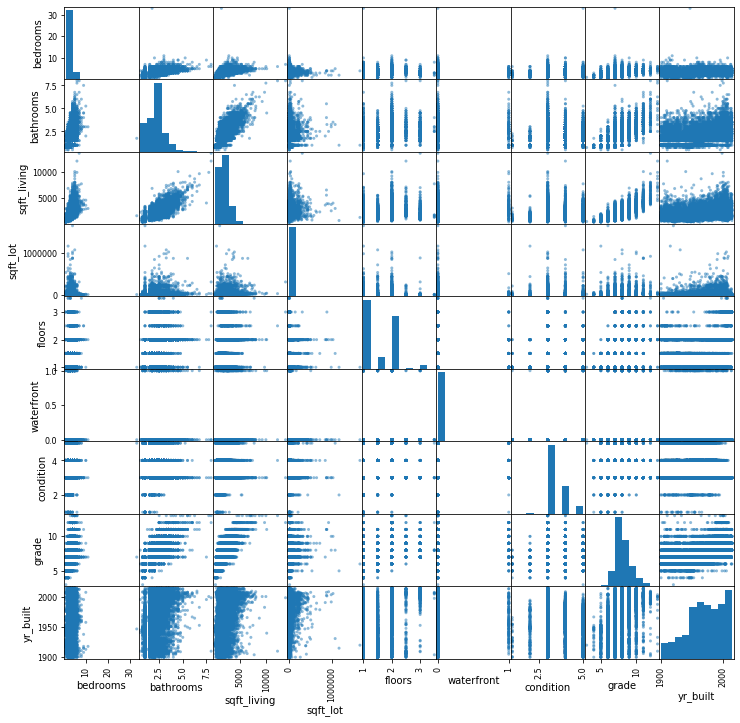

In [34]:
pd.plotting.scatter_matrix(df_scatter, figsize=(12,12))
plt.show()

### Notes on Scatter Matrix Dist:
- A lot of our data correlated with yr_built does not show a trend.
- That's why we need to normalize our data, because "year" is on such a different scale than say, bedrooms.

### Price Density Histogram

In [ ]:
# From this we can see that generally, most houses are priced below one million dollars
plt.figure(figsize = (12,8))
sns.distplot(df.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

### Waterfront-Price Density Histogram
Let's show another type of distribution now that we have "waterfront" column cleaned up

In [30]:
# Density histogram of house price - waterfront vs. non-waterfront:
water_df =  df.loc[df['waterfront'] == 1]
no_water_df =  df.loc[df['waterfront'] == 0]

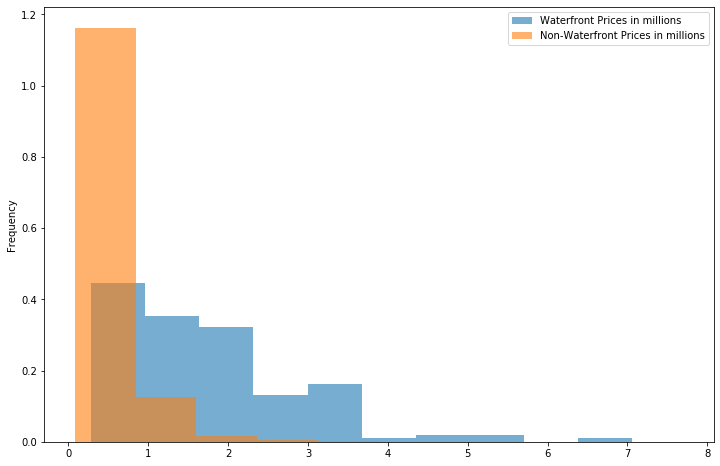

In [31]:
# Plot histograms (with densities on the y-axis) for waterfront and non-waterfront house prices:
plt.figure(figsize = (12,8))
binsize = 10
water_df.price_millions.plot.hist(bins = binsize, density = True,  alpha = 0.6, label ="Waterfront Prices in millions");
no_water_df.price_millions.plot.hist(bins = binsize, density = True, alpha = 0.6, label = 'Non-Waterfront Prices in millions');
plt.legend()
plt.show()


### Interpret Waterfront-Price Density Histogram
- Waterfront properties tend to have higher selling prices than non-waterfront properties
- Waterfront properties have a higher spread than non-watefront properties - that's why the waterfront peak is smaller than the non-waterfront peak
- Neither price distributions are normally distributed
- Waterfront and non-waterfront properties overlap in price from about .3-.7 million

### Waterfront-Price KDE

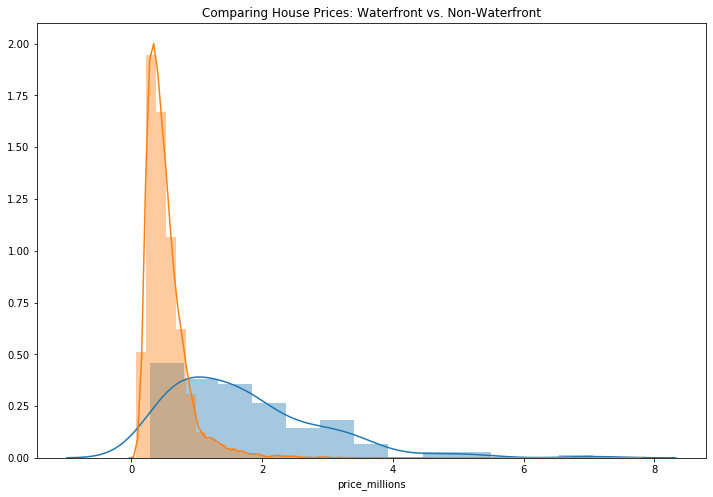

In [32]:
# Ok. Now let's draw a smooth curve, given the above data, using KDE (kernal density estimation)
# The smooth line in the visualization below is an estimate of the distributions of waterfront and non-waterfront house prices
# The parameter bandwidth rules the smoothness of the underlying distribution

# The problem with a Probability Density Function plot, is that all "point probabilities" are 0
# We must calculate the area under the curve for an interval to get the actual probability for an interval of house prices.
# Thus, it's not intuitive or easy to "read" the y-axis to get probabilities for continuous variables using a PDF like below.

plt.figure(figsize = (12,8))
sns.distplot(water_df.price_millions,kde=True)
sns.distplot(no_water_df.price_millions,kde=True)
plt.title('Comparing House Prices: Waterfront vs. Non-Waterfront')
plt.show()




### Probability of Waterfront Price 2-4 mill
For example, if we wanted to know the probability that a waterfront house price is between 2 and 4 million dollars (inclusive), we would use the following formula to take the integral of this range (AKA area under the curve)
$$\large P(2 \leq X \leq 4) = \int_{2}^{4} f_x(x) dx \geq 0 $$


# DATA PREPARATION
- Prepping to model
- Missing values
- Convert categorical data to numeric via one-hot encoding (we didn't need to do this because everything is ordinal and non-text)
- Type conversions (this was done in the previous section - price to millions and sqft to acres)
- Remove multicollinearity (correlated predictors)
- Normalize numeric data


## Normalize Numeric Data
-  The z-score normalization method is the most common
- If standard deviation is a yardstick, then a z-score is the measurement expressed in terms of that yardstick
- For example, if we find the z-score for a given x-value's distance from x-bar  divided by the standard deviation...
- We have convereted the distance of x from x-bar to "standard deviation units"
- If s = 30, then we want to see how many s's (quantities of 30) that x is from x-bar
- Basically, a z-score expresses each value of x as a standard unit away from the mean (x-bar)

In [ ]:
# make copy of df_model for normalization purposes: 
df_scale = df.copy()

# Apply z-score normalization:
def z_score_norm(my_column):
    return (my_column - my_column.mean())/my_column.std()
for predictor in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition','grade','yr_built']:
    df_scale[predictor] = z_score_norm(df_scale[predictor])
# print normalized data: 
print(df_scale)

## Multicollinearity
- If a column has a high VIF value, it may be prudent to drop it from the linear regression model

In [36]:
correlations = df_model.corr()

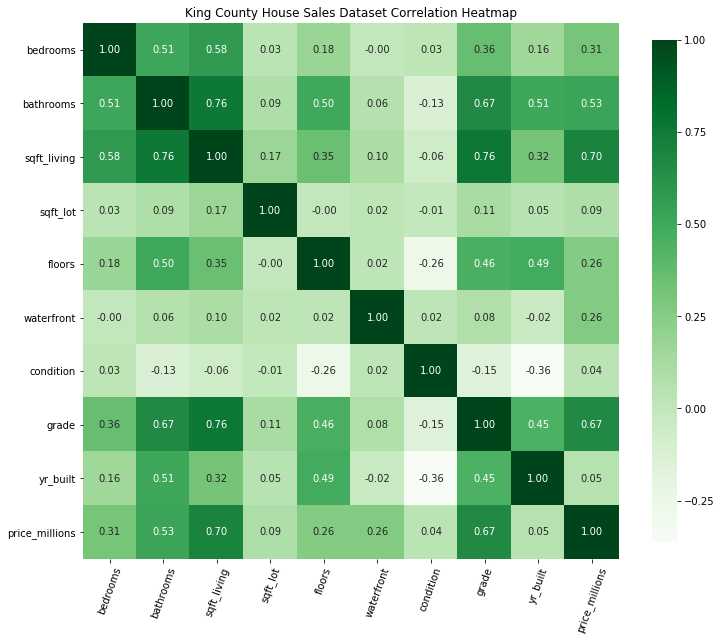

In [37]:
plt.figure(figsize=(12,12)) # Set size of figure
# Use df.corr() as your matrix for the heatmap
# I set the color scheme to green using cmap
# annot= True adds the float value on each square
# fmt='.1f' sets the number of decimal places for each float number. If you want 1.00, for example, use fmt='.2f'
# cbar_kws={"shrink": .77}  - this argument shrinks the side color bar to .77 of its original size
# square=True - this argument makes the figure square
ax = sns.heatmap(correlations, cmap = "Greens", annot=True, fmt='.2f', cbar_kws={"shrink": .77}, square=True)
# Sets the title
ax.set(title='King County House Sales Dataset Correlation Heatmap')
# Get the y-axis limit values for the size of the figure:
bottom, top = ax.get_ylim()
# Add .5 to the bottom and top of the y-axis limits to fix an error where the top and bottom squares are cut off
# This is an error for the versions of Seaborne and Matplotlib I'm using
ax = ax.set_ylim(bottom + 0.5, top - 0.5)
# Rotate the bottom labels by 30 degrees (100-70)
plt.xticks(rotation=70)
plt.show()


In [38]:
correlations["price_millions"].sort_values(ascending=False)

price_millions    1.000000
sqft_living       0.701917
grade             0.667951
bathrooms         0.525906
bedrooms          0.308787
waterfront        0.264306
floors            0.256804
sqft_lot          0.089876
yr_built          0.053953
condition         0.036056
Name: price_millions, dtype: float64

In [39]:
correlations["sqft_living"].sort_values(ascending=False)

sqft_living       1.000000
grade             0.762779
bathrooms         0.755758
price_millions    0.701917
bedrooms          0.578212
floors            0.353953
yr_built          0.318152
sqft_lot          0.173453
waterfront        0.104637
condition        -0.059445
Name: sqft_living, dtype: float64

### The feature highest correlated with price is sqft_living

Text(0, 0.5, 'House Sale Price')

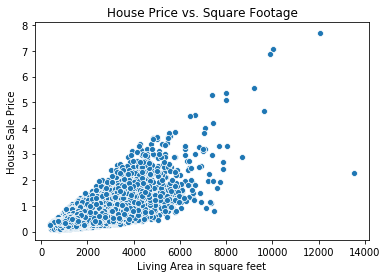

In [40]:
ax = sns.scatterplot(x="sqft_living", y="price_millions", data=df_model)
ax.set_title("House Price vs. Square Footage")
ax.set_xlabel("Living Area in square feet")
ax.set_ylabel("House Sale Price")



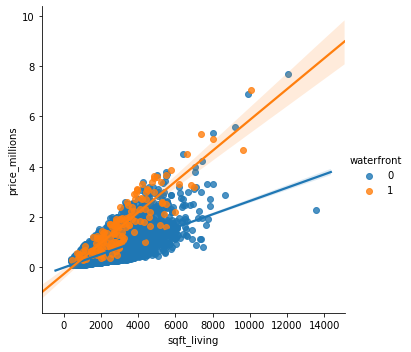

In [41]:
sns.lmplot(x="sqft_living", y="price_millions", data=df_model, hue="waterfront")


# MODELING
- Tune models to get the highest performance possible on our task
  - Considerations:
    - What kind of task? Classification task? Regression task?
    - Which models will we use
    - Will be use regularization?
    - How will we validate our model?
    - Loss functions?
    - What is the performance threshold for success?


## Linear Regression - Ordinary Least Squares

In [48]:
# Split normalized data into target variable and predictors/explanatory variables/independent variables
X = df_scale.drop('price_millions', axis=1) # independent variables
y = df_scale['price_millions'] # target variable

In [49]:
# Divide into test and train data
# Train data is for us to estimate our OLS model
# Test data is to parameterize our model, using that model to predict y values (price)
# If test_size = .3, that means 30% of our data is set aside for teh testing data
# And 70% of that data for training

# The parameter "random_state" ensures that if there is skew in our data, our 30-70 split is randomly taking from these groups
# So we have good proportions of randomly selected data and our 30-70 split has good representation 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)


In [50]:
# Linear Regressor - Ordinary Least Squares regression-type estimate:
lr = LinearRegression()

In [74]:
# Use Cross-validation to inspect model:
cvs = cross_val_score(estimator=lr, X=X_train, 
                                    y=y_train, 
                                    cv=10, scoring='r2')
print('CV score: %.3f ± %.3f' % (cvs.mean(), cvs.std()))

CV score: 0.640 ± 0.018


In [76]:
# Train model based on train dataset:
# Regressing the X's onto the y:
# We're getting a fit here, having used 70% of the data
lr.fit(X_train, y_train)
coef_list = list(lr.coef_)
name_list = list(X_train.columns)
pd.Series(coef_list, index=name_list)

bedrooms      -0.047497
bathrooms      0.041209
sqft_living    0.167322
sqft_lot      -0.011066
floors         0.010240
waterfront     0.060507
condition      0.010099
grade          0.150145
yr_built      -0.113141
dtype: float64

In [52]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [53]:
# Model Evaluation:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6418071120403939


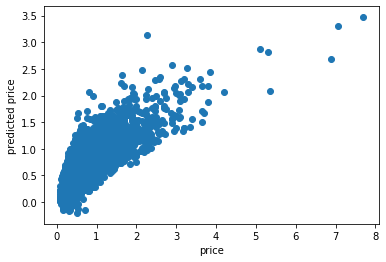

In [54]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price')
plt.ylabel('predicted price')
plt.show()

### Interpret price vs. predicted price scatterplot:
- The distribution isn't a straight line, and from that we know that there is something non-linear going on in the relationships we've modeled. 
- We don't have a good linear relationship between price and our predictors

Text(0, 0.5, 'residuals')

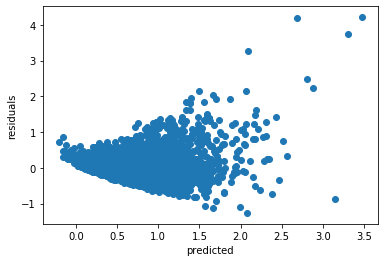

In [55]:
# Inspect the amount of error we got from our OLS Linear Regression:
# The residual is the amount of error in the estimation (difference between predicted and actual y values)
# The error is between .6 and -0.2, which is pretty wide

plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

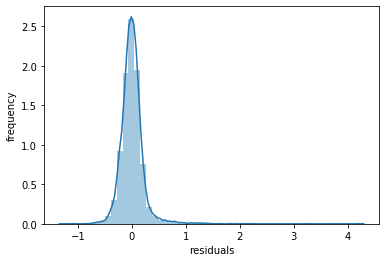

In [56]:
# Check Distribution of Errors:
# We can see from this that there's some right-skew to the distribution of error
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

### Interpretation of Regression Model
- We could remove outliers
- This is a very onerous and finicky process
- We might lose useful information if we pick out the outliers

In [57]:
# Finally, we take the 30% of that data we set aside for testing, and examine the error for that:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))



The R squared value is: 0.6530001064251156


In [58]:
# So looks like in-sample, out-of-sample is not as robust as we might want, 
# since our R-squared value is less than when using train data

## Random Forest Regressor - Decision Tree Regression-type Estimate

In [59]:
# Multiple Regression Trees are used
forest = RandomForestRegressor()

In [60]:
forest.fit(X_train, y_train)

/Users/clairesarraille/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [61]:
# Model prediction based on train dataset:
forest_predict_y_train = forest.predict(X_train)

In [62]:
# Model Evaluation:
print('The R squared value is: ' + str(metrics.r2_score(y_train, forest_predict_y_train)))

The R squared value is: 0.9448994364652239


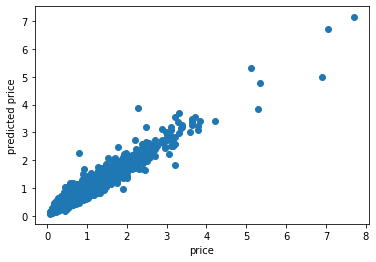

In [63]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, forest_predict_y_train)
plt.xlabel('price')
plt.ylabel('predicted price')
plt.show()

Text(0, 0.5, 'residuals')

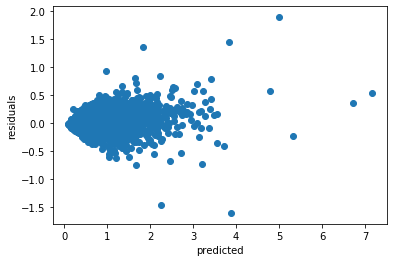

In [64]:
# Error from Random Forest Regressor:
# The error is between .20 and -0.15, which is better than it was for OLS Regression 

plt.scatter(forest_predict_y_train, y_train - forest_predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

In [65]:
# We've done in-sample for Random Forest, now let's do out of sample:
forest_predict_y_test = forest.predict(X_test)

In [66]:
# Model Evaluation:
print('The R squared value is: ' + str(metrics.r2_score(y_test, forest_predict_y_test)))

The R squared value is: 0.7036442724427945


### Interpretation of R Squared value from above:
- Going from .945 for the traning data (in-sample) to .700 for the test data (out of sample)
- That's a pretty steep difference
- This means that our model is not robust
- However, our model is still performing relatively well
